In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

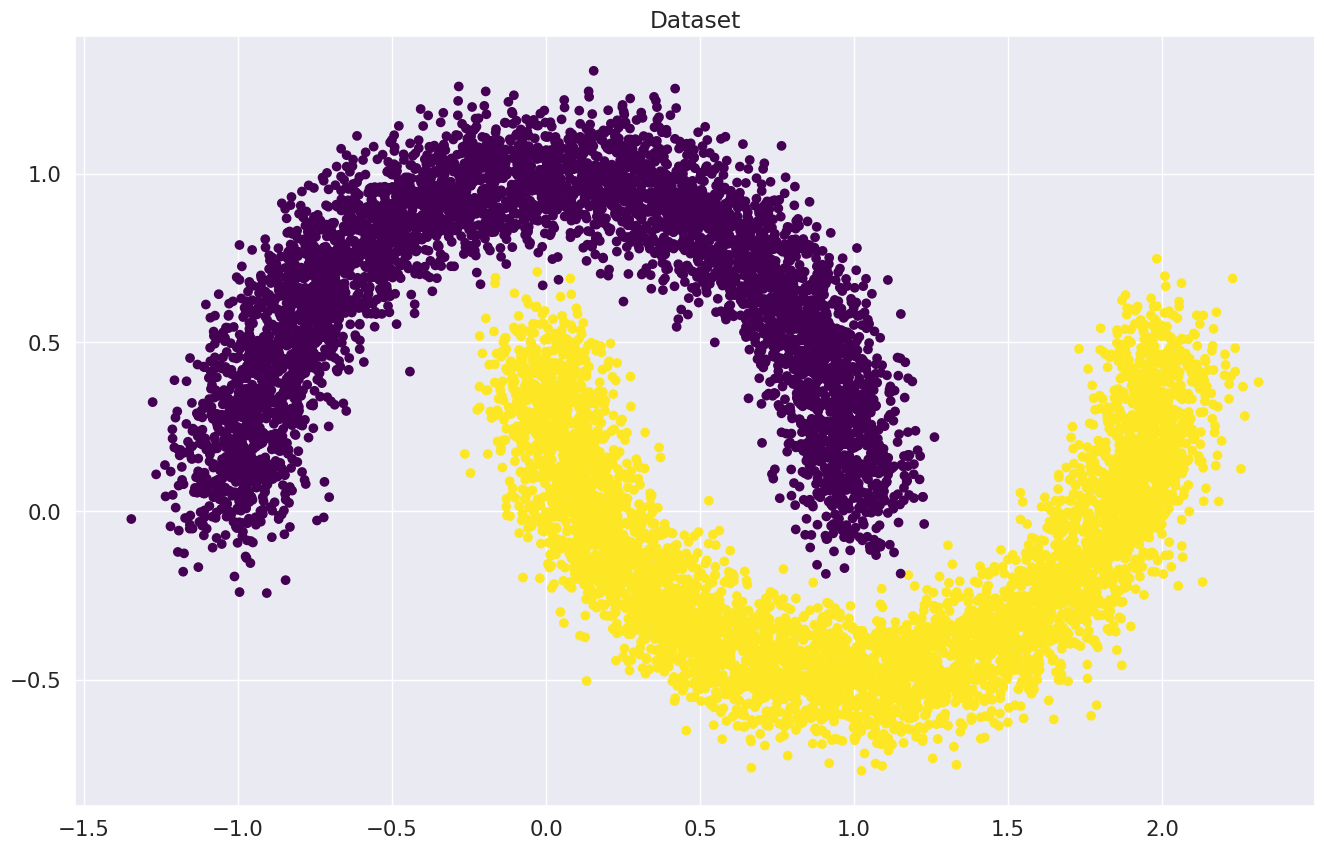

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [5]:
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_val_t = torch.from_numpy(X_val).float()
y_val_t = torch.from_numpy(y_val).float()

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((in_features, out_features)))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn((out_features)))

    def forward(self, x):
        x = x@self.weights
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [9]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[-1.1145],
         [ 0.2830]], requires_grad=True),
 Parameter containing:
 tensor([-0.8105], requires_grad=True)]

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights).float()
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch.float())# YOUR CODE. Use linear_regression to get outputs
        outp = outp.reshape(y_batch.shape)
        loss = loss_function(outp, y_batch)# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.359375
Iteration: 100
Batch accuracy: 0.8359375
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125
Iteration: 800
Batch accuracy: 0.84375

Iteration: 814.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 519.

### Визуализируем результаты

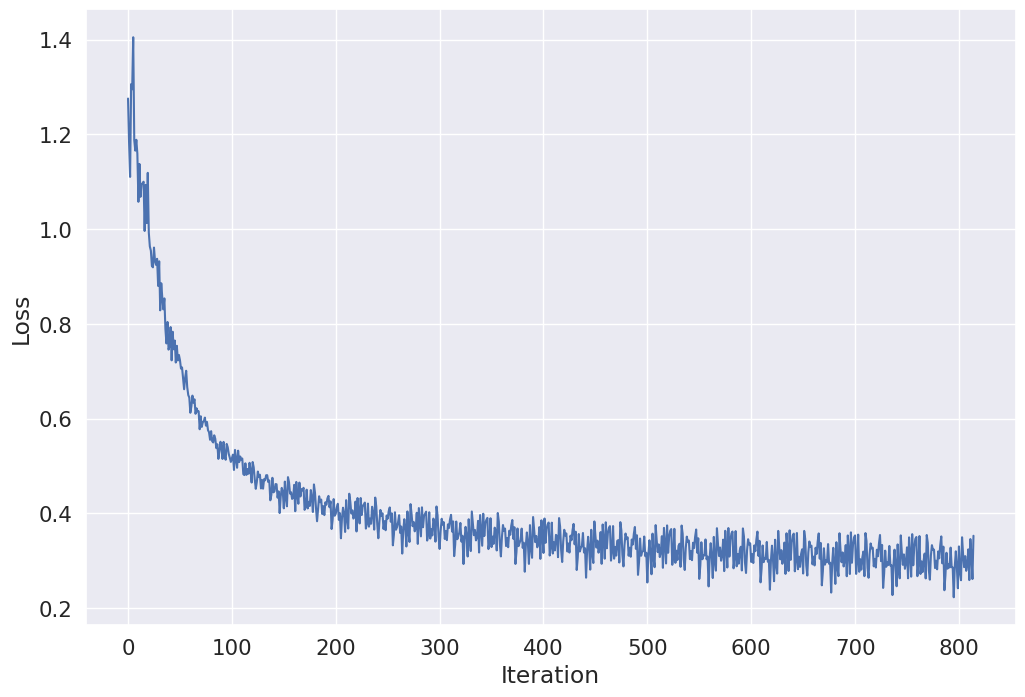

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

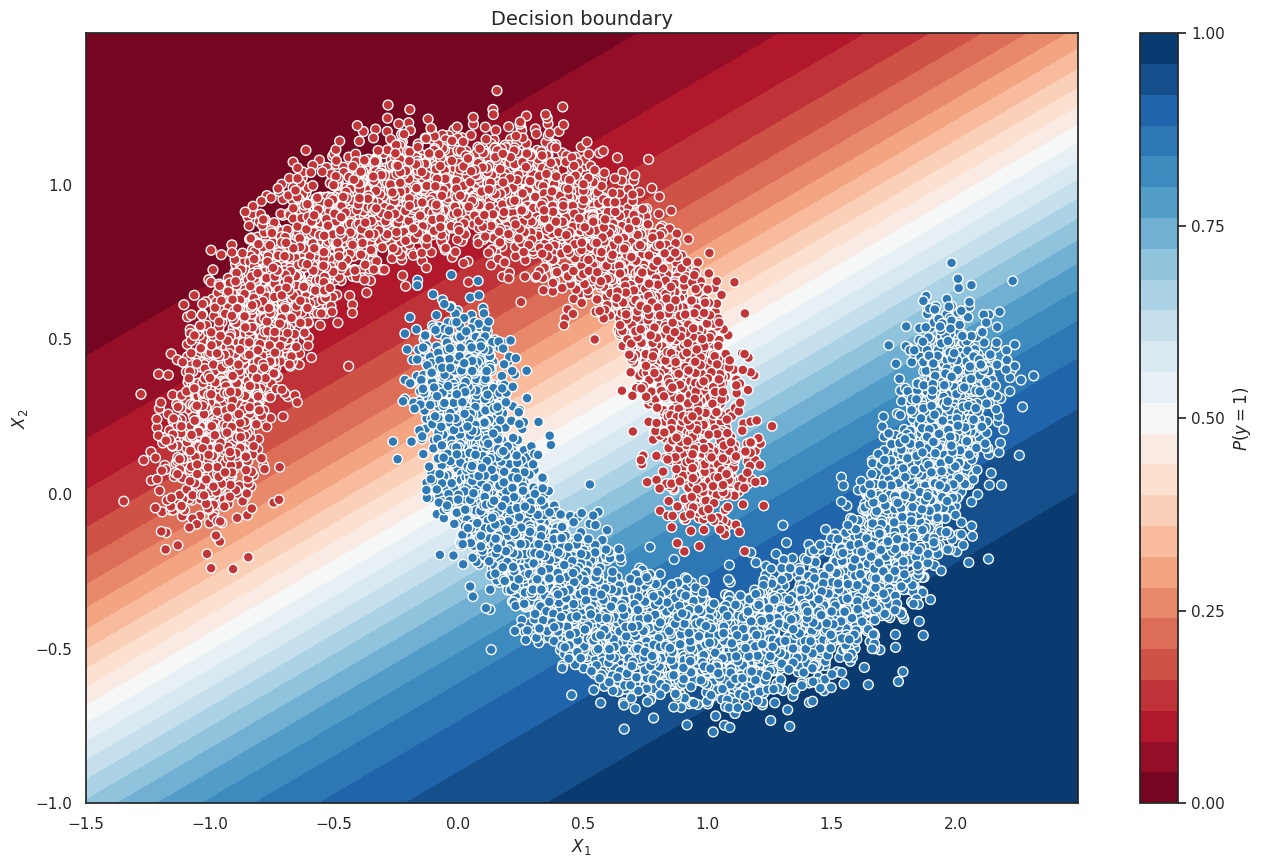

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probabilities = torch.sigmoid(model.forward(x_batch.float()))
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

accuracy_score(predict(val_dataloader, linear_regression),  np.array(y_val_t))

0.8644

In [16]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=784, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=784, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 106046690.98it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47804141.21it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26689917.40it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20266519.97it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [18]:
activation = nn.ELU

features = 784
classes = 10
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, classes),
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [20]:
device = "cuda" #if torch.cuda.is_available() else "cpu"

In [21]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)


            #print(outp.shape)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all


            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()


        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8080860633727175
Loader: valid. Accuracy: 0.9069940476190477
Epoch: 2
Loader: train. Accuracy: 0.9080290010741139
Loader: valid. Accuracy: 0.921875
Epoch: 3
Loader: train. Accuracy: 0.9250637755102041
Loader: valid. Accuracy: 0.9363307823129252
Epoch: 4
Loader: train. Accuracy: 0.9395978786251342
Loader: valid. Accuracy: 0.9458971088435374
Epoch: 5
Loader: train. Accuracy: 0.949281686358754
Loader: valid. Accuracy: 0.9544005102040817
Epoch: 6
Loader: train. Accuracy: 0.9568676154672395
Loader: valid. Accuracy: 0.9583333333333334
Epoch: 7
Loader: train. Accuracy: 0.9629262889366272
Loader: valid. Accuracy: 0.9617346938775511
Epoch: 8
Loader: train. Accuracy: 0.9668703007518797
Loader: valid. Accuracy: 0.9640731292517006
Epoch: 9
Loader: train. Accuracy: 0.9696227175080558
Loader: valid. Accuracy: 0.9672619047619048
Epoch: 10
Loader: train. Accuracy: 0.9719891245972073
Loader: valid. Accuracy: 0.9677933673469388


In [22]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.9069940476190477,
 0.921875,
 0.9363307823129252,
 0.9458971088435374,
 0.9544005102040817,
 0.9583333333333334,
 0.9617346938775511,
 0.9640731292517006,
 0.9672619047619048,
 0.9677933673469388]

In [23]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    activation = activation

    features = 784
    classes = 10
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(features, 128),
      activation(),
      nn.Linear(128, 128),
      activation(),
      nn.Linear(128, classes)
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    device = "cuda" if torch.cuda.is_available() else "cpu"
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all

                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [24]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8121979054779807
Loader: valid. Accuracy: 0.9050807823129252
Epoch: 2
Loader: train. Accuracy: 0.9017689312567132
Loader: valid. Accuracy: 0.9127338435374149
Epoch: 3
Loader: train. Accuracy: 0.9087674543501612
Loader: valid. Accuracy: 0.9159226190476191
Epoch: 4
Loader: train. Accuracy: 0.9117380504833512
Loader: valid. Accuracy: 0.9186862244897959
Epoch: 5
Loader: train. Accuracy: 0.9143394199785178
Loader: valid. Accuracy: 0.9185799319727891
Epoch: 6
Loader: train. Accuracy: 0.9161352040816326
Loader: valid. Accuracy: 0.9205994897959183
Epoch: 7
Loader: train. Accuracy: 0.91734358216971
Loader: valid. Accuracy: 0.9212372448979592
Epoch: 8
Loader: train. Accuracy: 0.918233082706767
Loader: valid. Accuracy: 0.920812074829932
Epoch: 9
Loader: train. Accuracy: 0.9191393662728249
Loader: valid. Accuracy: 0.9211309523809523
Epoch: 10
Loader: train. Accuracy: 0.919827470461869
Loader: valid. Accuracy: 0.9207057823129252
Epoch: 1
Loader: train. Accuracy: 

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

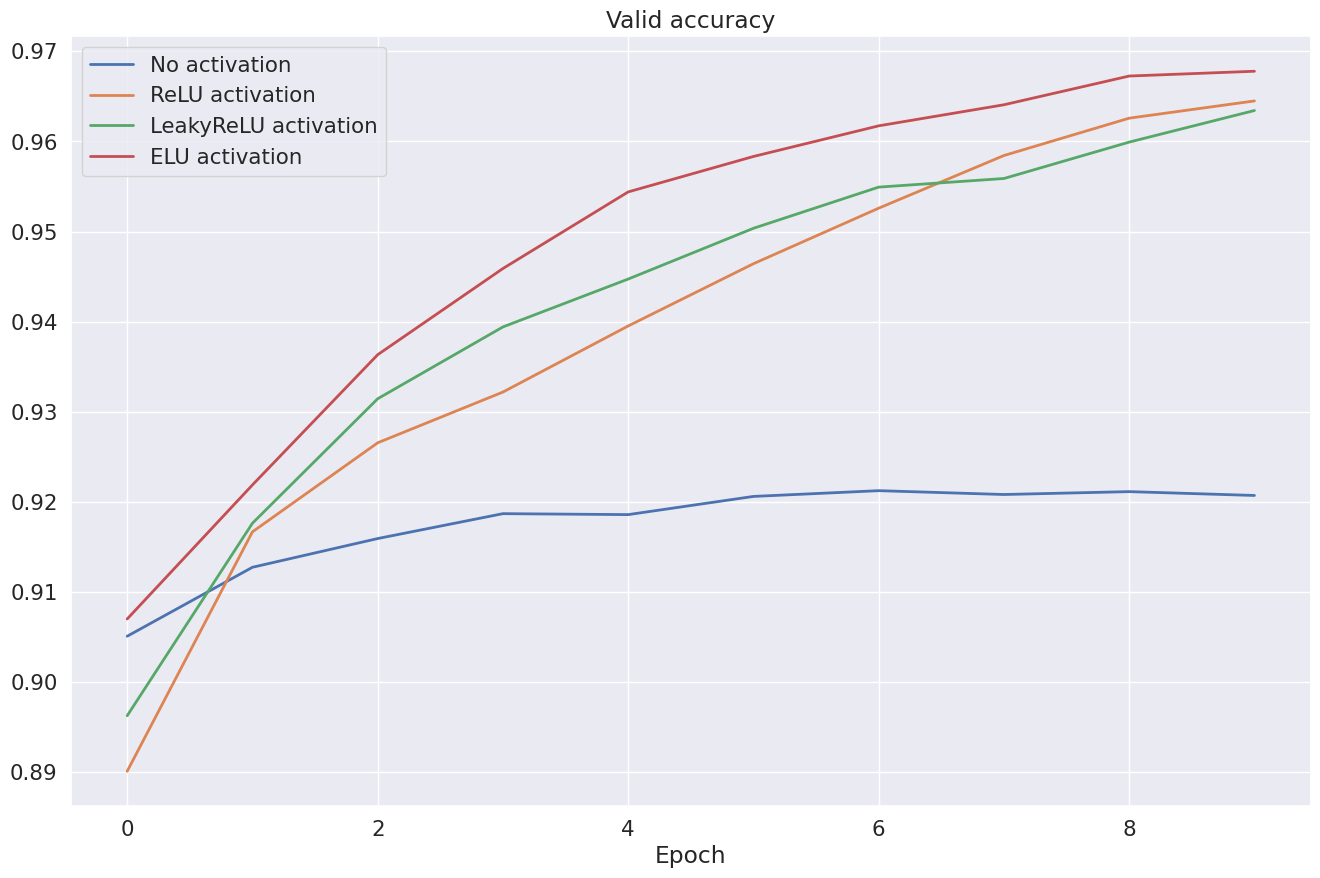

In [25]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

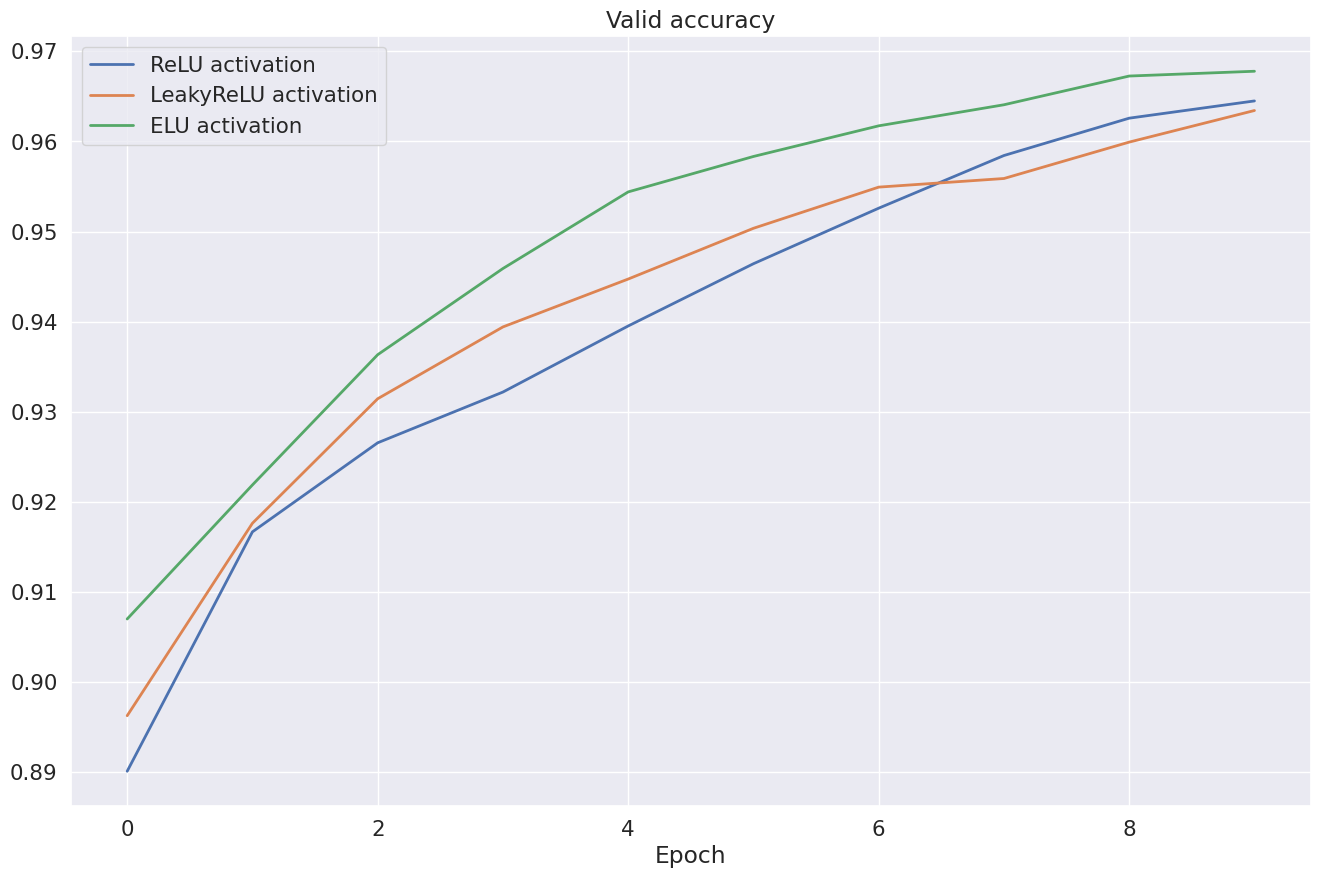

In [26]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        x = torch.flatten(x, 1)
        #x = x.view(-1, 4 * 4 * 16) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [120]:
train_dataloader = DataLoader(train_dataset, batch_size=784, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=784, drop_last=True)

In [121]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [122]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)


            #print(outp.shape)
            preds = outp.argmax(-1)
            correct = (preds.cuda() == y_batch).sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all


            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()


        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7084284371643395
Loader: valid. Accuracy: 0.8809523809523809
Epoch: 2
Loader: train. Accuracy: 0.9043199516648764
Loader: valid. Accuracy: 0.9328231292517006
Epoch: 3
Loader: train. Accuracy: 0.9407223415682062
Loader: valid. Accuracy: 0.9561011904761905
Epoch: 4
Loader: train. Accuracy: 0.9579081632653061
Loader: valid. Accuracy: 0.9657738095238095
Epoch: 5
Loader: train. Accuracy: 0.9663835929108485
Loader: valid. Accuracy: 0.9725765306122449
Epoch: 6
Loader: train. Accuracy: 0.9713345864661654
Loader: valid. Accuracy: 0.9756590136054422
Epoch: 7
Loader: train. Accuracy: 0.9741205692803437
Loader: valid. Accuracy: 0.9766156462585034
Epoch: 8
Loader: train. Accuracy: 0.9763191460794844
Loader: valid. Accuracy: 0.9765093537414966
Epoch: 9
Loader: train. Accuracy: 0.9784170247046187
Loader: valid. Accuracy: 0.9761904761904762
Epoch: 10
Loader: train. Accuracy: 0.9804645542427497
Loader: valid. Accuracy: 0.9765093537414966


In [123]:
lenet_accuracy = accuracy["valid"]

In [124]:
lenet_accuracy

[0.8809523809523809,
 0.9328231292517006,
 0.9561011904761905,
 0.9657738095238095,
 0.9725765306122449,
 0.9756590136054422,
 0.9766156462585034,
 0.9765093537414966,
 0.9761904761904762,
 0.9765093537414966]

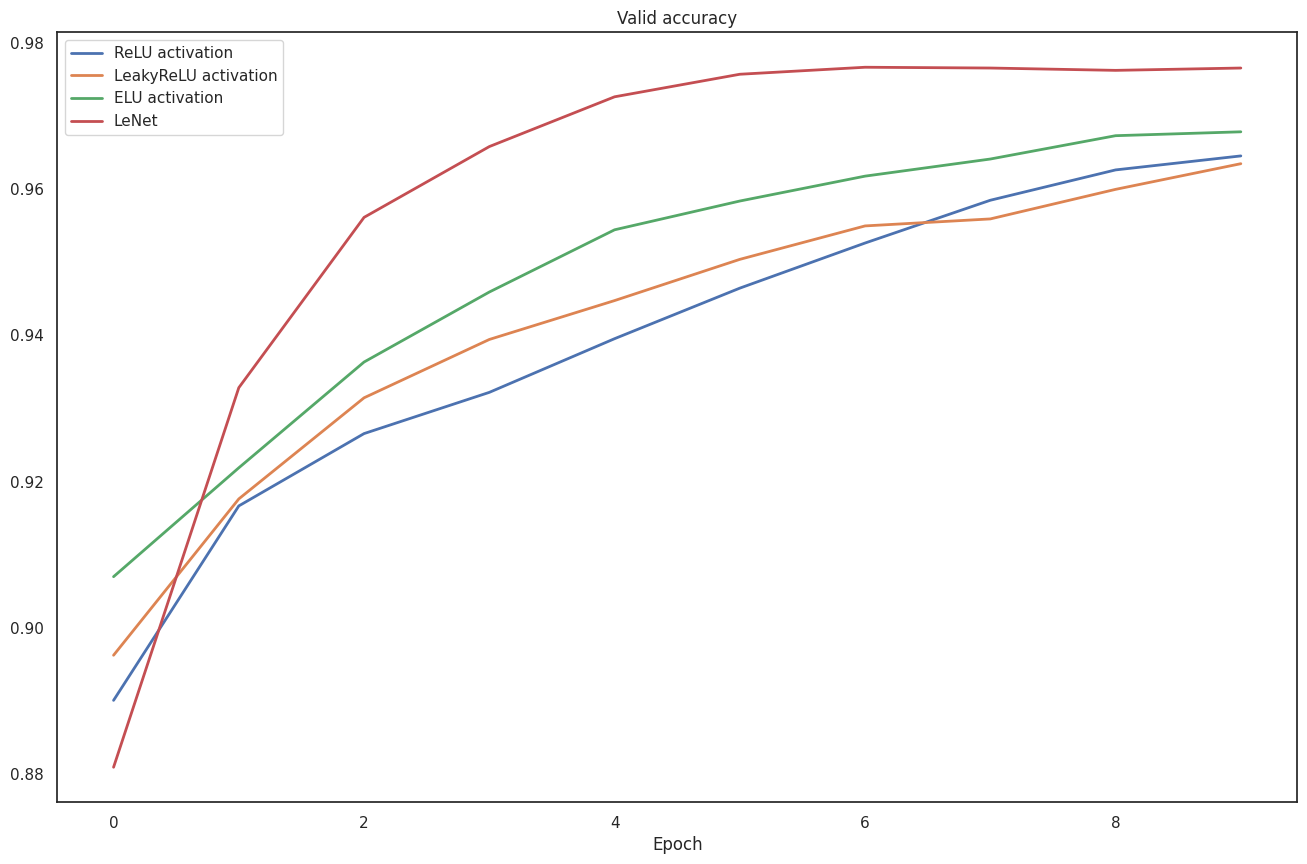

In [125]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()